### Reinforcement Learning - Resource Manager

Kudos to:

https://www.gymlibrary.dev/content/environment_creation/

https://www.youtube.com/watch?v=bD6V3rcr_54&ab_channel=NicholasRenotte 

Version 1.1:

- Export the Environment to python file
    - Register it
- Add Deep Learning with DQN



### Imports

In [1]:
import gym
from gym import spaces
import numpy as np
import pygame
from gym.envs.registration import register
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Environment

In [2]:
from ResourceManagerEnvironment import ResourceManagerEnv

In [3]:
#register the environment
register(
    id='Resource-Manager-v1-1',
    #loading syntax: 'PythonFileName:EnvironmentClassName'
    entry_point='ResourceManagerEnvironment:ResourceManagerEnv',
    max_episode_steps=300,
)


In [4]:
env = gym.make('Resource-Manager-v1-1')

c:\Users\denni\.conda\envs\tf\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 10)
  logger.warn(


## Deep Learning

In [5]:
class DQNAgent:
    def __init__(self, num_actions, grid_size, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, learning_rate=0.001, gamma=0.99):
        #define number of action, here we have 4 actions: up, down, left, right
        self.num_actions = num_actions
        self.grid_size = grid_size

        #hyperparameters
        self.batch_size = 32
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.learning_rate = learning_rate
        self.gamma = gamma

        #define q_network and target_network
        self.q_network = self.build_q_network()
        self.target_network = self.build_q_network()

    def build_q_network(self):
        model = keras.Sequential([
            keras.layers.Input(shape=(self.grid_size, self.grid_size)),  # Define the state shape
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(self.num_actions)  # Output layer with num_actions units
            ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model


    def choose_action(self, state):

        action = np.random.randint(self.num_actions)
        '''
        if np.random.rand() < self.epsilon:
            #explore action space randomly
            action = np.random.randint(self.num_actions)
        else:
            #exploit learned values
            q_values = self.q_network(state[None, :])
            action = np.argmax(q_values[0])
        '''
        return action

    def train(self, state, action, reward, next_state, terminated):
        #state = np.array(state)
        state = np.expand_dims(state, axis=0)
        #get the Q-values of the current state
        q_values = self.q_network.predict(state)
        #print(f"Q-values: {q_values}")

        #calculate the target Q-values using the Bellman equation
        if terminated:
            q_values[0][action] = reward
        else:
            next_q_values = self.target_network.predict(next_state)
            q_values[0][action] = reward + self.gamma * np.max(next_q_values)

        #train the Q-network using the updated Q-values
        loss = self.q_network.train_on_batch(state, q_values)

        return loss



    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def decay_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


In [6]:
num_actions = 4
grid_size = 15

env = ResourceManagerEnv(grid_size=grid_size)
dqn_agent = DQNAgent(num_actions, grid_size=grid_size)

In [7]:
#number of episodes
episodes = 100
#maximum steps per episode
max_steps = 300

#store rewards for each episode here
rewards = []
episode_rewards = []

for episode in range(episodes):
    state = env.reset()
    terminated = False
    total_reward = 0

    for step in range(max_steps):
        #choose an action using the epsilon-greedy strategy
        action = dqn_agent.choose_action(state)
        #Used for printing q values and see which action is chosen
        #print(f"Selected action: {action}")

        #take the chosen action and observe the next state, reward, and whether the episode is done
        next_state, reward, terminated, _, info = env.step(action)

        total_reward += reward

        # Train the agent using the observed experience
        dqn_agent.train(state, action, reward, next_state, terminated)

        # Update the current state
        state = next_state

        #save total rewards for each episode
        rewards.append(total_reward)
        #print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {dqn_agent.epsilon}")
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        if terminated or total_reward < -200:
            break
    episode_rewards.append(total_reward)

    # Perform any necessary updates after an episode (e.g., decay epsilon, update target network)
    dqn_agent.decay_epsilon()
    dqn_agent.update_target_network()


1/1 [==============================] - 0s 67ms/step
Episode 1, Total Reward: -1
1/1 [==============================] - 0s 20ms/step
Episode 1, Total Reward: -2
1/1 [==============================] - 0s 23ms/step
Episode 1, Total Reward: -3
1/1 [==============================] - 0s 20ms/step
Episode 1, Total Reward: -4
1/1 [==============================] - 0s 21ms/step
Episode 1, Total Reward: -5
1/1 [==============================] - 0s 23ms/step
Episode 1, Total Reward: -6
1/1 [==============================] - 0s 21ms/step
Episode 1, Total Reward: -7
1/1 [==============================] - 0s 24ms/step
Episode 1, Total Reward: -8
1/1 [==============================] - 0s 26ms/step
Episode 1, Total Reward: -9
1/1 [==============================] - 0s 31ms/step
Episode 1, Total Reward: -10
1/1 [==============================] - 0s 45ms/step
Episode 1, Total Reward: -11
1/1 [==============================] - 0s 49ms/step
Episode 1, Total Reward: -12
1/1 [==============================] 

## Evaluation

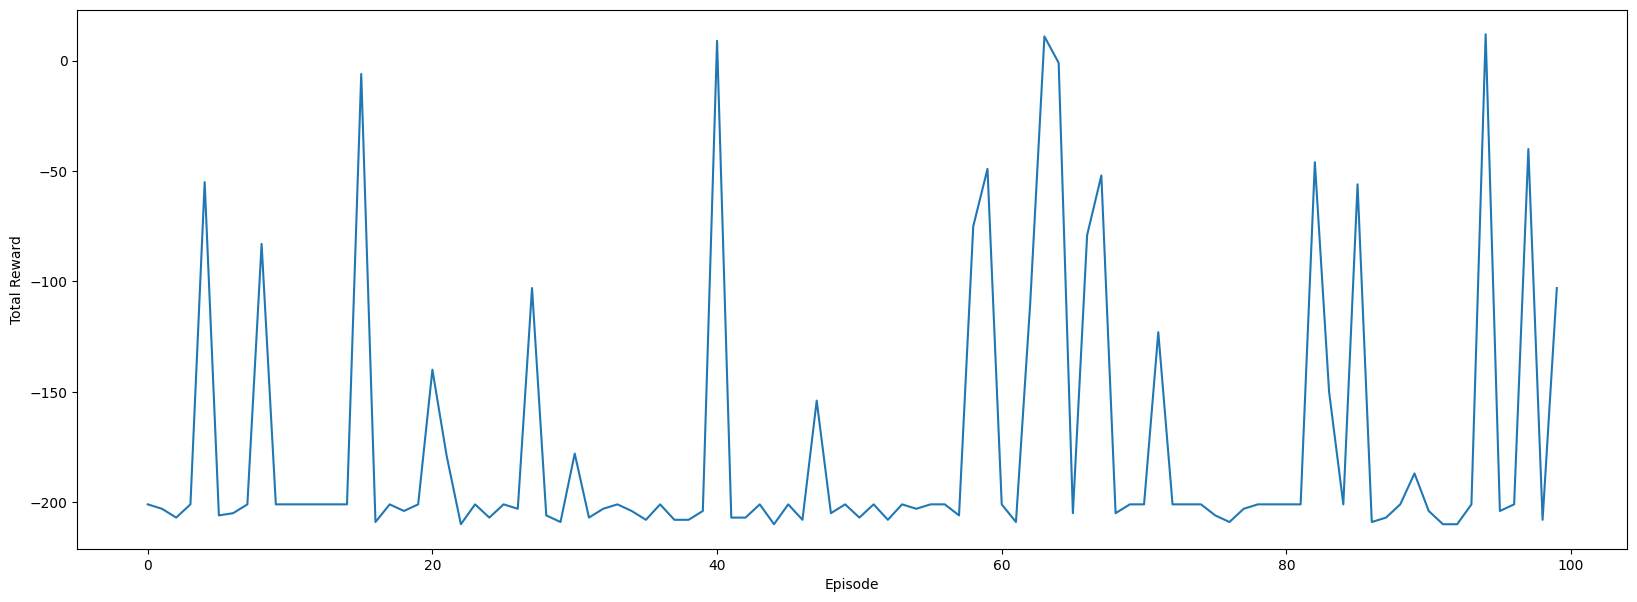

In [14]:
#plot episode rewards over episodes
plt.figure(figsize=(20, 7))
plt.plot([i for i in range(len(episode_rewards))], episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()